In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

In [3]:
from mochi import f_beta_01,runLGBM,check_feature_importance

In [4]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [5]:
config.feature_dict.keys()

dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding'])

In [6]:
config.feature_dict['trade_and_recent_login_comparing']

['device_comparing_login_1',
 'device_comparing_login_2',
 'ip_comparing_login_1',
 'ip_comparing_login_2',
 'city_comparing_login_1',
 'city_comparing_login_2',
 'log_from_comparing_login_1',
 'log_from_comparing_login_2',
 'result_comparing_login_1',
 'result_comparing_login_2',
 'type_comparing_login_1',
 'type_comparing_login_2',
 'login_distance_0',
 'login_distance_1',
 'login_distance_2']

In [7]:
config.feature_dict['recent_login_detail']

['timelong_login_0',
 'timelong_login_1',
 'timelong_login_2',
 'log_from_login_0',
 'log_from_login_1',
 'log_from_login_2',
 'result_login_0',
 'result_login_1',
 'result_login_2',
 'type_login_0',
 'type_login_1',
 'type_login_2',
 'is_scan_login_0',
 'is_scan_login_1',
 'is_scan_login_2',
 'day_login_0',
 'day_login_1',
 'day_login_2',
 'weekday_login_0',
 'weekday_login_1',
 'weekday_login_2',
 'hour_login_0',
 'hour_login_1',
 'hour_login_2',
 'day_cycle_login_0',
 'day_cycle_login_1',
 'day_cycle_login_2',
 'weekday_cycle_login_0',
 'weekday_cycle_login_1',
 'weekday_cycle_login_2',
 'hour_cycle_login_0',
 'hour_cycle_login_1',
 'hour_cycle_login_2',
 'has_trade_login_0',
 'has_trade_login_1',
 'has_trade_login_2',
 'recent_login_number']

In [8]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

In [9]:
validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

### Validation

In [10]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.990044	test's auc: 0.981344
[200]	train's auc: 0.995075	test's auc: 0.988255
[300]	train's auc: 0.998865	test's auc: 0.989281
Early stopping, best iteration is:
[295]	train's auc: 0.998737	test's auc: 0.989461
f_beta score for the turn 1 is 0.908041511738
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.991418	test's auc: 0.96527
[200]	train's auc: 0.997513	test's auc: 0.972283
[300]	train's auc: 0.9995	test's auc: 0.971547
Early stopping, best iteration is:
[265]	train's auc: 0.998407	test's auc: 0.973487
f_beta score for the turn 2 is 0.875679647318
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993741	test's auc: 0.978437
[200]	train's auc: 0.997381	test's auc: 0.98424
[300]	train's auc: 0.999329	test's auc: 0.984606
[400]	train's auc: 0.999827	test's auc: 0.985575
[500]	train's auc: 0.999951	test's auc: 0.986048
Early stopping, 

In [11]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('ip_t_encoding', 171523.87705748685),
 ('id_t_encoding', 87184.493302030285),
 ('device_t_encoding', 39594.786839216547),
 ('login_distance_0', 24187.290008764921),
 ('trade_times_360', 8048.9500209895687),
 ('type_3_count_30', 5577.737616939452),
 ('device_repeat_count_360', 5016.5656692425837),
 ('period_4_login_rate_30', 4595.2256016992587),
 ('timelong_std_1', 4530.8988788316792),
 ('timelong_max_1', 4132.78695003558),
 ('login_distance_1', 3790.7418289207426),
 ('type_3_rate_30', 3629.6794441551219),
 ('period_3_login_rate_360', 3391.9187721253643),
 ('period_4_login_rate_360', 3222.9969369712953),
 ('type_login_0', 2661.3976116856788),
 ('success_1_rate_30', 2605.6237627423575),
 ('trade_login_rate_360', 2457.4054154141436),
 ('timelong_min_30', 2435.0847684123919),
 ('login_success_rate_360', 2217.1179892073255),
 ('timelong_std_3', 2198.4343574504219),
 ('ip_used_count_7', 2114.8846472811961),
 ('hour', 2019.6862613878068),
 ('timelong_min_15', 1936.3875888587368),
 ('fail_-2

<Container object of 366 artists>

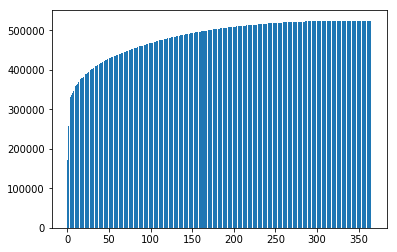

In [12]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

考虑在230左右截断

In [13]:
top_features =  [x[0] for x in sorted_feature_importacne][0:250]
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [14]:
#top 250 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.989386	test's auc: 0.983628
[200]	train's auc: 0.995165	test's auc: 0.988846
[300]	train's auc: 0.998795	test's auc: 0.990473
Early stopping, best iteration is:
[281]	train's auc: 0.998311	test's auc: 0.990943
f_beta score for the turn 1 is 0.908041511738
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993271	test's auc: 0.96636
[200]	train's auc: 0.997702	test's auc: 0.971493
[300]	train's auc: 0.999469	test's auc: 0.970444
Early stopping, best iteration is:
[220]	train's auc: 0.998037	test's auc: 0.971983
f_beta score for the turn 2 is 0.875679647318
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993991	test's auc: 0.98001
[200]	train's auc: 0.997589	test's auc: 0.98446
[300]	train's auc: 0.999345	test's auc: 0.984931
[400]	train's auc: 0.999817	test's auc: 0.986393
[500]	train's auc: 0.99994	test's auc: 0.986589
Early stopping, 

In [15]:
#top 270 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.8, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.989386	test's auc: 0.983628
[200]	train's auc: 0.995165	test's auc: 0.988846
[300]	train's auc: 0.998795	test's auc: 0.990473
Early stopping, best iteration is:
[281]	train's auc: 0.998311	test's auc: 0.990943
f_beta score for the turn 1 is 0.928802356491
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993271	test's auc: 0.96636
[200]	train's auc: 0.997702	test's auc: 0.971493
[300]	train's auc: 0.999469	test's auc: 0.970444
Early stopping, best iteration is:
[220]	train's auc: 0.998037	test's auc: 0.971983
f_beta score for the turn 2 is 0.950816522574
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993991	test's auc: 0.98001
[200]	train's auc: 0.997589	test's auc: 0.98446
[300]	train's auc: 0.999345	test's auc: 0.984931
[400]	train's auc: 0.999817	test's auc: 0.986393
[500]	train's auc: 0.99994	test's auc: 0.986589
Early stopping, 

In [17]:
dir(config)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data_path',
 'feature_dict',
 'feature_path',
 'model_features',
 'result_path',
 'single_module_validation_indice_set',
 'trade_train_size',
 'train_2_6_index']

In [21]:
top_features

['ip_t_encoding',
 'id_t_encoding',
 'device_t_encoding',
 'login_distance_0',
 'trade_times_360',
 'type_3_count_30',
 'device_repeat_count_360',
 'period_4_login_rate_30',
 'timelong_std_1',
 'timelong_max_1',
 'login_distance_1',
 'type_3_rate_30',
 'period_3_login_rate_360',
 'period_4_login_rate_360',
 'type_login_0',
 'success_1_rate_30',
 'trade_login_rate_360',
 'timelong_min_30',
 'login_success_rate_360',
 'timelong_std_3',
 'ip_used_count_7',
 'hour',
 'timelong_min_15',
 'fail_-2_rate_30',
 'trade_times_30',
 'timelong_med_360',
 'city_used_count_30',
 'device_repeat_rate_360',
 'timelong_mean_1',
 'device_used_count_7',
 'ip_used_count_30',
 'period_3_login_rate_30',
 'device_most_used_id_counts_360',
 'timelong_mean_360',
 'type_3_rate_360',
 'ip_most_used_id_rate_360',
 'timelong_std_15',
 'period_3_login_times_360',
 'device_same_id_login_count_360',
 'city_most_freq_rate_360',
 'timelong_med_1',
 'day',
 'login_distance_2',
 'city_used_count_360',
 'period_3_trade_rate

In [22]:
config.model_features['model_h1_top250'] = top_features

In [23]:
pd.to_pickle(config,'config.pkl')